# Retrieval-система по статьям с arXiv

## Этап 1. Исследовательский анализ (EDA)

In [ ]:
CSV_PATH = r'nlp_s3_project\test_sample.csv'
ARXIV_METADATA_PATH = r'nlp_s3_project\arxiv-metadata-s.json'

### Анализ test_sample.csv

Первые 5 строк из test_sample.csv:
                id                                           abstract  \
0       2412.16732    A new platinate was recently discovered when...   
1  nucl-th/9602019    The production cross sections of various fra...   
2       2501.05500    This survey provides a comprehensive examina...   
3       2506.20892  A critical challenge for operating fusion burn...   
4       2208.02031    In this work, we present the first corpus fo...   

                                               query  
0  What unique composition and decomposition beha...  
1  How does the inclusion of statistical decay af...  
2  What are the core components of modern zero-kn...  
3  How does impurity seeding affect the timing an...  
4  What is the primary challenge of the newly dev...  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        

True

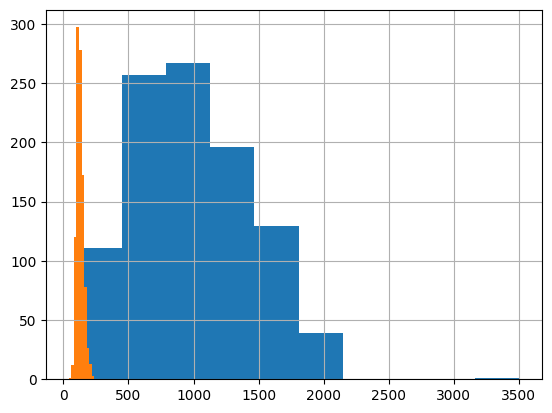

In [56]:
import pandas as pd


data = pd.read_csv(CSV_PATH)


print("Первые 5 строк из test_sample.csv:")
print(data.head())
print(data.info())

abstract_len = data['abstract'].str.len()
query_len = data['query'].str.len()

print(f"\nСтатистика аннотаций в test_sample.csv:")
abstract_len.hist()
print(f"\nСтатистика длин запросов в test_sample.csv:")
query_len.hist()
data['id'].nunique() == len(data)

### Анализ arxiv-metadata-s.json


Первые 5 статей из arxiv_metadata:
{'id': '0704.0038', 'submitter': 'Maxim A. Yurkin', 'authors': 'Maxim A. Yurkin, Alfons G. Hoekstra', 'title': 'The discrete dipole approximation: an overview and recent developments', 'comments': '36 pages, 1 figure; added several corrections according to the\n  published erratum except for Eq.(5) (it was correct in the original paper)', 'journal-ref': 'J.Quant.Spectrosc.Radiat.Transf. 106, 558-589 (2007); Erratum:\n  J.Quant.Spectrosc.Radiat.Transf. 171, 82-83 (2016)', 'doi': '10.1016/j.jqsrt.2007.01.034 10.1016/j.jqsrt.2015.11.025', 'report-no': None, 'categories': 'physics.optics physics.comp-ph', 'license': 'http://creativecommons.org/licenses/by-nc-nd/4.0/', 'abstract': '  We present a review of the discrete dipole approximation (DDA), which is a\ngeneral method to simulate light scattering by arbitrarily shaped particles. We\nput the method in historical context and discuss recent developments, taking\nthe viewpoint of a general framework base

dict_keys(['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi', 'report-no', 'categories', 'license', 'abstract', 'versions', 'update_date', 'authors_parsed'])

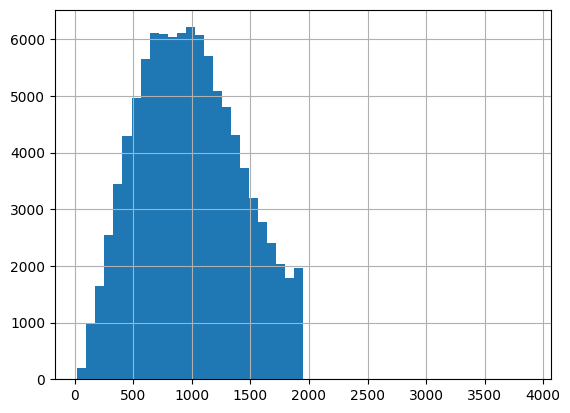

In [57]:
import json
import pandas as pd


with open(ARXIV_METADATA_PATH) as f:
    arxiv_metadata = json.load(f)


print()
print("Первые 5 статей из arxiv_metadata:")
for i in range(5):
    print(arxiv_metadata[i])
print()
print(f"Всего статей в arxiv_metadata: {len(arxiv_metadata)}")

abstracts = [item["abstract"] for item in arxiv_metadata]
abs_len = pd.Series([len(a) for a in abstracts])

print(abs_len.describe())
abs_len.hist(bins=50)
arxiv_metadata[0].keys()

Все ли id уникальны

In [58]:
len({item["id"] for item in arxiv_metadata}) == len(arxiv_metadata)

True

Топ 30 категорий

In [59]:
import collections

cats = [item["categories"].split() for item in arxiv_metadata]
flat = [c for sub in cats for c in sub]
freq = collections.Counter(flat).most_common(30)
freq

[('cs.LG', 8152),
 ('hep-ph', 6692),
 ('hep-th', 6111),
 ('quant-ph', 5783),
 ('cs.CV', 5668),
 ('cs.AI', 4842),
 ('gr-qc', 4096),
 ('astro-ph', 3754),
 ('cond-mat.mtrl-sci', 3634),
 ('cond-mat.mes-hall', 3380),
 ('cs.CL', 3202),
 ('math-ph', 2981),
 ('math.MP', 2981),
 ('cond-mat.stat-mech', 2782),
 ('cond-mat.str-el', 2762),
 ('math.CO', 2585),
 ('stat.ML', 2570),
 ('astro-ph.GA', 2563),
 ('astro-ph.CO', 2476),
 ('math.AP', 2333),
 ('astro-ph.SR', 2288),
 ('astro-ph.HE', 2241),
 ('math.PR', 2202),
 ('nucl-th', 2200),
 ('hep-ex', 2053),
 ('math.AG', 1950),
 ('math.OC', 1907),
 ('cs.IT', 1783),
 ('math.IT', 1783),
 ('physics.optics', 1772)]

Размер заголовков

count    98213.000000
mean        75.222486
std         27.661516
min          7.000000
25%         55.000000
50%         72.000000
75%         92.000000
max        381.000000
dtype: float64


<Axes: >

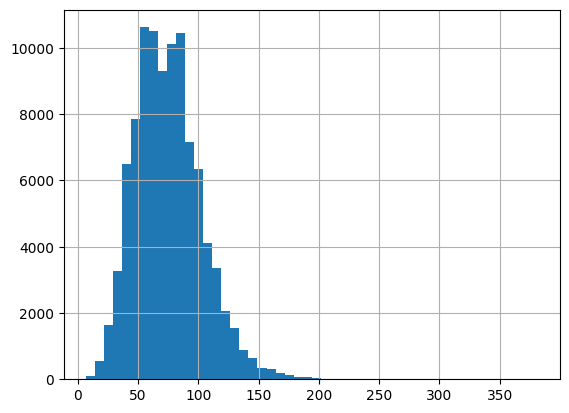

In [60]:
titles = [item["title"] for item in arxiv_metadata]
title_len = pd.Series([len(t) for t in titles])
print(title_len.describe())
title_len.hist(bins=50)

Выводы по EDA:
- Абстракты в среднем около 1000 символов, но резко обрываются на 2000 символах.
- Заголовки в среднем около 75 мимволов с максимумом в 350 символов.
- Все id уникальны.
- Категории статей разнообраззные.
- В полном корпусе 98 213 уникальных статей — достаточно мало, чтобы начать с точного индекса (Flat), без HNSW.
- Аннотации длинные (до ~2000 символов у основной массы), поэтому можно ограничиться усечением без чанкинга.
- Запросы сильно короче документов (≈80 символов против ≈1000), что определяет необходимость dense-bi-encoder подхода.
- Чанкинг не используем, поскольку метрика определяется на уровне статьи, и корректнее работать с одним embedding на статью.
- Для построения векторных представлений будет использоваться только текстовое содержимое статьи — title и abstract, поскольку остальные поля (authors, categories, comments и др.) нерелевантны смысловому поиску.
- будем использовать модель sentence-transformers/all-MiniLM-L6-v2 из-за баланса скорости и качаства, а также достаточного окна в 512 токенов (покрывает более 99.2% документов. Проверенно за кадром).

## Этап 2. Реализация retrieval-системы

In [ ]:
import time
import faiss
import numpy as np
import torch
from sentence_transformers import SentenceTransformer, CrossEncoder
from typing import List, Dict, Tuple
from tqdm import tqdm


class RetrievalSystem:
    def __init__(self,
                 model_name: str = "sentence-transformers/all-MiniLM-L6-v2",
                 reranker_name: str = "cross-encoder/ms-marco-MiniLM-L-6-v2"):
        
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model = SentenceTransformer(model_name, device=self.device)
        self.reranker = CrossEncoder(reranker_name, device=self.device)
        self.index = None
        self.ids = []
        self.documents = []
        self.metadata = []

    def encode(self, texts: List[str], batch_size: int = 32) -> np.ndarray:
        emb = self.model.encode(
            texts,
            batch_size=batch_size,
            convert_to_numpy=True,
            show_progress_bar=False
        )

        emb = emb / np.linalg.norm(emb, axis=1, keepdims=True)
        return emb.astype("float32")

    def build_index(
        self,
        documents: List[str],
        ids: List[str],
        metadata: List[Dict],
        batch_size: int = 32
    ):
        self.documents = documents
        self.ids = ids
        self.metadata = metadata

        all_embeddings = []

        for i in tqdm(range(0, len(documents), batch_size), desc="Encoding documents"):
            batch = documents[i : i + batch_size]
            emb = self.encode(batch)
            all_embeddings.append(emb)

        all_embeddings = np.vstack(all_embeddings)

        dim = all_embeddings.shape[1]
        self.index = faiss.IndexFlatIP(dim)
        self.index.add(all_embeddings)

    def retrieve(self,
                 query: str,
                 top_k: int = 5,
                 initial_k: int = 100,
                 batch_size: int = 32) -> Tuple[List[Dict], float, float, float]:
        t0 = time.perf_counter()
        query_emb = self.encode([query])
        t1 = time.perf_counter()

        scores, indices = self.index.search(query_emb, initial_k)
        t2 = time.perf_counter()

        candidates = []
        for pos, idx in enumerate(indices[0]):
            candidates.append({
                "id": self.ids[idx],
                "score": float(scores[0][pos]),
                "text": self.documents[idx],
                "meta": self.metadata[idx]
            })

        pairs = [(query, c["text"]) for c in candidates]
        rerank_scores = self.reranker.predict(pairs, batch_size=batch_size)
        t3 = time.perf_counter()

        ranked = sorted(
            zip(rerank_scores, candidates),
            key=lambda x: x[0],
            reverse=True
        )

        results = [
            {
                "id": cand["id"],
                "score": float(score),
                "text": cand["text"],
                "meta": cand["meta"]
            }
            for score, cand in ranked[:top_k]
        ]

        encode_time = t1 - t0
        search_time = t2 - t1
        rerank_time = t3 - t2

        return results, encode_time, search_time, rerank_time
    
# Построение индекса
retrieval_system = RetrievalSystem() 
documents = [item["title"] + " " + item["abstract"] for item in arxiv_metadata]
ids = [item["id"] for item in arxiv_metadata]
metadata = arxiv_metadata
retrieval_system.build_index(documents, ids, metadata)

Encoding documents: 100%|██████████| 3070/3070 [02:16<00:00, 22.51it/s]


Проверка запроса

In [62]:
query = "What is the role of attention mechanisms in neural networks?"
results, encode_time, search_time, rerank_time = retrieval_system.retrieve(query, top_k=5, initial_k=10)
print("Top 5 results:")
for res in results:
    print(f"Document ID: {res['id']}, Score: {res['score']}, meta: {res['meta']}")

print(f"\nEncode time: {encode_time:.4f} seconds")
print(f"Search time: {search_time:.4f} seconds")
print(f"Rerank time: {rerank_time:.4f} seconds")

Top 5 results:
Document ID: 2210.16101, Score: 6.293506145477295, meta: {'id': '2210.16101', 'submitter': 'Zhongzhan Huang', 'authors': 'Zhongzhan Huang, Senwei Liang, Mingfu Liang, Liang Lin', 'title': 'A Generic Shared Attention Mechanism for Various Backbone Neural\n  Networks', 'comments': 'Work in progress. arXiv admin note: text overlap with\n  arXiv:1905.10671', 'journal-ref': None, 'doi': None, 'report-no': None, 'categories': 'cs.CV cs.AI', 'license': 'http://arxiv.org/licenses/nonexclusive-distrib/1.0/', 'abstract': "  The self-attention mechanism has emerged as a critical component for\nimproving the performance of various backbone neural networks. However, current\nmainstream approaches individually incorporate newly designed self-attention\nmodules (SAMs) into each layer of the network for granted without fully\nexploiting their parameters' potential. This leads to suboptimal performance\nand increased parameter consumption as the network depth increases. To improve\nthis 

# Этап 3. Оценка качества системы

Запросы для тестовой выборки + время работы частей

In [63]:
all_preds = []
true_ids = []

enc_times = []
search_times = []
rer_times = []

for _, row in tqdm(data.iterrows(), total=len(data)):
    query = row["query"]
    correct_id = row["id"]

    true_ids.append(correct_id)

    results, t_enc, t_search, t_rer = retrieval_system.retrieve(query, top_k=5, initial_k=15)

    all_preds.append([r["id"] for r in results])

    enc_times.append(t_enc)
    search_times.append(t_search)
    rer_times.append(t_rer)

print("Среднее время encode:", np.mean(enc_times))
print("Среднее время search:", np.mean(search_times))
print("Среднее время rerank:", np.mean(rer_times))
print("Общее среднее время:", np.mean(enc_times) + np.mean(search_times) + np.mean(rer_times))

100%|██████████| 1000/1000 [00:49<00:00, 20.23it/s]

Среднее время encode: 0.0064292306003626435
Среднее время search: 0.0058428528029471636
Среднее время rerank: 0.03676089249365032
Общее среднее время: 0.049032975896960124


Функция расчета MRR@5

In [64]:
def compute_mrr5(predictions, true_ids):
    mrr = 0.0

    for pred, true_id in zip(predictions, true_ids):
        rank = None
        for r, pid in enumerate(pred, start=1):
            if pid == true_id:
                rank = r
                break

        if rank is not None:
            mrr += 1 / rank

    return mrr / len(true_ids)

mrr5 = compute_mrr5(all_preds, true_ids)
print("MRR@5:", mrr5)

MRR@5: 0.9264000000000001


### Выводы 

Сначала была сделана система sentence-transformers/all-MiniLM-L6-v2 + IndexFlatIP с поиском top-5 (документов всего ~100к, это немного). Метрика получилась MRR@5 ≈ 0.60. После добавления нормализации эмбеддингов качество поднялось до 0.80. Далее были варианты: усиливать модель эмбеддингов или добавить реранкер. Я выбрал реранкер: добавил cross-encoder на той же серии моделей, стал доставать initial_k=10 и реранкать до top_k=5. В итоге получил MRR@5 = 0.92. Время на один запрос около 36 мс, что достаточно быстро. 

Ниже приведён эксперимент, где проверялось, какого качества можно добиться при разных initial_k. Плато примерно на уровне 0.94, при времени около 0.12 секунды на запрос.

# Приложение: зависимость MRR@5 и времени от initial_k

k=200: 100%|██████████| 1000/1000 [08:19<00:00,  2.00it/s]


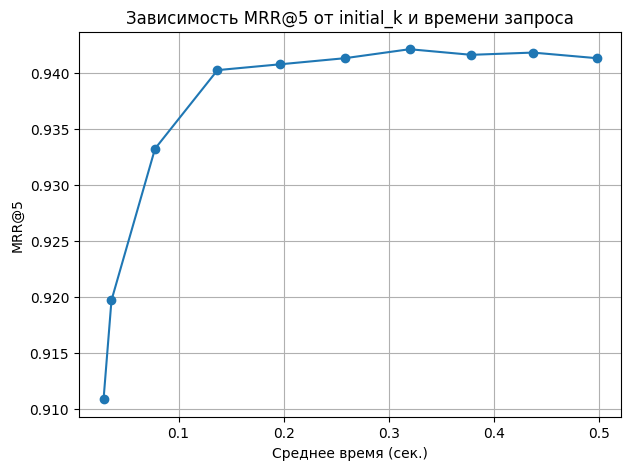

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

ks = [7, 10, 25, 50, 75, 100, 125, 150, 175, 200]
mrrs = []
times = []

for k in ks:
    preds = []
    enc_t, search_t, rer_t = [], [], []
    for _, row in tqdm(data.iterrows(), total=len(data), desc=f"k={k}"):
        q = row["query"]
        tid = row["id"]
        res, te, ts, tr = retrieval_system.retrieve(q, top_k=5, initial_k=k)
        preds.append([r["id"] for r in res])
        enc_t.append(te)
        search_t.append(ts)
        rer_t.append(tr)
    mrr = compute_mrr5(preds, data["id"].tolist())
    mrrs.append(mrr)
    times.append(np.mean(enc_t) + np.mean(search_t) + np.mean(rer_t))

plt.figure(figsize=(7,5))
plt.plot(times, mrrs, marker="o")
plt.xlabel("Среднее время (сек.)")
plt.ylabel("MRR@5")
plt.title("Зависимость MRR@5 от initial_k и времени запроса")
plt.grid(True)
plt.show()
